<a href="https://colab.research.google.com/github/omermosa/Fully-Connected-ANN-uisng-Cupy/blob/main/PMDL_A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd /content/drive/My Drive/PMDL/A2


/content/drive/My Drive/PMDL/A2


In [ ]:
!wget http://download.tensorflow.org/example_images/flower_photos.tgz

/content/drive/My Drive/PMDL/A2
--2020-11-03 04:47:46--  http://download.tensorflow.org/example_images/flower_photos.tgz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.218.128, 2a00:1450:4013:c08::80
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.218.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228813984 (218M) [application/x-compressed-tar]
Saving to: ‘flower_photos.tgz’

flower_photos.tgz   100%[===================>] 218.21M  35.0MB/s    in 6.0s    

2020-11-03 04:47:53 (36.3 MB/s) - ‘flower_photos.tgz’ saved [228813984/228813984]



In [ ]:
! tar -xvzf /content/drive/My\ Drive/PMDL/A1/Part1/flower_photos.tgz

# Data Load and Preprocessing

In [ ]:
import os
import cv2 
import numpy as np
from skimage.transform import resize #to resize img

In [ ]:
def load_data():
  pd="/content/drive/My Drive/PMDL/A2/flower_photos"
  dirs=sorted(os.listdir(pd))
  flowers_train=[]
  classes_train=[]
  flowers_test=[]
  classes_test=[]
  c=1
  for f in dirs:
    dir=os.path.join(pd,f)
    if os.path.isdir(dir):
      fs=sorted(os.listdir(dir))
      cls=[]
      cl=len(fs)
      for j,k in enumerate(fs):
        #read img, then resize to 32 by 32 (I tried multiple sizes and this yeilded best accuracy)
        img=(cv2.imread(os.path.join(dir,k)))
        img = resize(img, (128, 128,3))
        if cl-(j+1)>=100: 
          flowers_train.append(np.array(img)) 
          classes_train.append(c)
        else:#keep last 100 of each class for test
          flowers_test.append(np.array(img)) 
          classes_test.append(c)
      c+=1
  flowers_train=np.array(flowers_train)
  classes_train=np.array(classes_train)
  flowers_test=np.array(flowers_test)
  classes_test=np.array(classes_test)
  #flatten the train and test data then return
  return (flowers_train.reshape(flowers_train.shape[0],-1),classes_train,flowers_test.reshape(flowers_test.shape[0],-1),classes_test)
    

In [ ]:
X_train,y_train,X_test,y_test=load_data()

In [ ]:
#shuffle the arrays
from sklearn.utils import shuffle
X_train,y_train=shuffle(X_train,y_train)
X_test,y_test=shuffle(X_test,y_test)

In [ ]:
#save arrays
np.save("X_train_128.npy",X_train)
np.save("y_train_128.npy",y_train)
np.save("X_test_128.npy",X_test)
np.save("y_test_128.npy",y_test)


In [ ]:
import numpy as np
np.random.seed(0) 


In [ ]:
import cupy as cp
cp.random.seed(0) 


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
import pickle

In [ ]:
#128 by 128 dataset
Xt=np.load('/content/drive/My Drive/PMDL/A2/X_train_128.npy')
Yt=np.load('/content/drive/My Drive/PMDL/A2/y_train_128.npy')
X_test=np.load('/content/drive/My Drive/PMDL/A2/X_test_128.npy')
y_test=np.load('/content/drive/My Drive/PMDL/A2/y_test_128.npy')

In [ ]:
# 64 * 64 dataset
Xt=np.load('/content/drive/My Drive/PMDL/A2/X_train_64.npy')
Yt=np.load('/content/drive/My Drive/PMDL/A2/y_train_64.npy')
X_test=np.load('/content/drive/My Drive/PMDL/A2/X_test_64.npy')
y_test=np.load('/content/drive/My Drive/PMDL/A2/y_test_64.npy')

In [ ]:
#32 32 dataset
Xt=np.load('/content/drive/My Drive/PMDL/A1/Part1/X_train.npy')
Yt=np.load('/content/drive/My Drive/PMDL/A1/Part1/y_train.npy')
X_test=np.load('/content/drive/My Drive/PMDL/A1/Part1/X_test.npy')
y_test=np.load('/content/drive/My Drive/PMDL/A1/Part1/y_test.npy')

In [ ]:
Xt=cp.array(Xt)
Yt=cp.array(Yt)
X_test=cp.array(X_test)
y_test=cp.array(y_test)

# ANN Class Implementation.

In [ ]:
class ANN(object): # fully connected NN Class

  def __init__(self,n_layers,n_nodes): # construct given layer architecture
    self.n_layers=n_layers
    self.n_nodes=n_nodes
    self.Ws=self.init_weights()

  def init_weights(self):
    Ws={}
    for i in range(self.n_layers):
      #use Xaveir intialization
      Ws['WL_'+str(i+1)]=cp.array(np.random.randn(self.n_nodes[i],self.n_nodes[i+1])/np.sqrt(self.n_nodes[i+1]))
      Ws['bL_'+str(i+1)]=cp.array(np.zeros((self.n_nodes[i+1],1)))
    self.Ws=Ws
    return Ws

  def activation(self,L,type='relu'): # activation functions.
    if type=='relu':
      return cp.maximum(0,L)
    elif type=='tanh':
      return cp.tanh(L)
    elif type=='sigmoid':
      return 1/(1+cp.exp(-L))
    elif type=='softmax':
      m=cp.max(L,axis=-1).reshape(-1,1)
      L=L-m
      return cp.exp(L)/cp.sum(cp.exp(L),axis=1,keepdims=True)

  def one_step_forward(self,activ_prev,layer_num,Ws,activ_fn='relu'): # one layer forward probgation (Wx+b ) then activation
    W,b=Ws['WL_'+str(layer_num)],Ws['bL_'+str(layer_num)]
    L=cp.dot(W.T,activ_prev.T)+b
    L=L.T
    activ_current=self.activation(L,activ_fn)
    return activ_current,L

  def forward_pass(self,X,Ws): # run forward probagation 
    activations=[X,]
    Ls=[X,]
    a_prev=X
    n_layers=self.n_layers
    for i in range(n_layers):
      if i+1<n_layers:
        a_prev,L=self.one_step_forward(a_prev,i+1,Ws) # default is relu , can be changed
        activations.append(a_prev)
        Ls.append(L)
      else:
        a_prev,L=self.one_step_forward(a_prev,i+1,Ws,'softmax') # softmax the last layer.
        activations.append(a_prev)
        Ls.append(L)

    yhat=activations[-1]

    return Ls,activations,yhat

  def loss(self,y_pred,y_true,ld,m,loss_fn='NLL'):
    id=np.eye(y_pred.shape[1])[cp.asnumpy(y_true).astype(np.int32)-1].astype(np.bool)
    reg_loss=0 #L2 Reg

    if ld>0: # if there is regulrization 
      for i in range(1,self.n_layers+1): # ld*sum(WL**2) /2*m
        reg_loss+=cp.sum(self.Ws['WL_'+str(i)]**2) 
      reg_loss/=(2*m)
      reg_loss*=ld

    if loss_fn=='NLL': # take - log of the correct class probability
      sms=cp.sum(y_pred,axis=1).reshape(-1,1)
      sm=y_pred[id].reshape(-1,1)/sms
      ls=1/m*cp.sum(-cp.log(sm)) # the y is already a softmax form, take - log
    
    # elif loss_fn=='hinge':
    #   delta=0.1
    #   margins=cp.maximum(0,y_pred-y_pred[id].reshape(-1,1)+delta)
    #   margins[id]=0
    #   ls=1/m*cp.sum(margins)
    return ls,ls+reg_loss

  def relu_der(self,L): #relu derivative
    grad=cp.ones((L.shape))
    grad[L<0]=0
    return grad

  def tanh_der(self,L): #tanh derivative
    return 1-cp.tanh(L)**2

  def output_grad(self,yp,yt,loss_fn='NLL'): # NLL derivative

    if loss_fn=='NLL':
      grad=(yp-yt)/cp.sum((yp),axis=1).reshape(-1,1)
    #hinge??
    return grad    


  def backward_pass(self,Ws,As,Ls,yp,yt):

    grads={}
    dActivs={} #grad of activations
    n_layers=self.n_layers
    m=yp.shape[0] #num examples
    WL=Ws['WL_'+str(n_layers)]
    # output layers grads
    dL=self.output_grad(yp,yt)
    Aprev=As[n_layers-1]

    dW=1/m*(cp.dot(Aprev.T,dL))

    db=1/m*(cp.sum(dL.T,axis=1,keepdims=True))

    grads['dWL_'+str(n_layers)]=dW
    grads['dbL_'+str(n_layers)]=db
    dActivs['Layer_'+str(n_layers-1)]=cp.dot(dL,WL.T)
    #rest of layers grad
    for i in reversed(range(n_layers-1)):
        Aprev=As[i]
        L=Ls[i+1]
        WL=Ws['WL_'+str(i+1)]
        
        dL=dActivs['Layer_'+str(i+1)]*(self.relu_der(L)) # 
        dW=1/m*(cp.dot(Aprev.T,dL))
        db = 1/m*(cp.sum(dL.T,axis=1,keepdims=True))
        
        grads['dWL_'+str(i+1)]=dW
        grads['dbL_'+str(i+1)]=db
        dActivs['Layer_'+str(i)]=cp.dot(dL,WL.T)
    return grads


  def update_Ws(self,grads,Ws,lr,ld,m): #GD update
    n_layers=self.n_layers
    for i in range(1,n_layers+1):
        Ws['bL_'+str(i)]-=lr*(grads['dbL_'+str(i)])
        Ws['WL_'+str(i)]-=lr*(grads['dWL_'+str(i)]+ld*  Ws['WL_'+str(i)]/m)
    return Ws

  def train_val_split(self,Xt,Yt,ratio): #split train and validation
    X_train,X_val,y_train,y_val=train_test_split(Xt,Yt,test_size=ratio)
    return ( X_train,X_val,y_train,y_val)


  def Train(self,Xt,Yt,n_epochs,lr,ld,train_val_ratio=0.1,batch_size=-1,verbose=True): # train the ANN on X,Y
    n_classes=len(cp.unique(Yt))
    lss_tr,ls_val=[],[]
    ac_tr,ac_val=[],[]

    X_train,X_val,y_train,y_val=self.train_val_split(Xt,Yt,train_val_ratio) # split train, val
    
    yt=cp.eye(n_classes)[cp.asnumpy(y_train).astype(cp.int32)-1]
    yv=cp.eye(n_classes)[cp.asnumpy(y_val).astype(cp.int32)-1]

    Ws=self.Ws
    m=Yt.shape[0] #num examples
    self.lr=lr
    self.ld=ld
    ts=y_train.shape[0]

    p=self.Predict(X_val)
    prev_val_acc=self.compute_acc(p,y_val)
    for i in range(n_epochs+1):
      
      if batch_size!=-1: # check if there is minibatches
        n_batches=ts//batch_size
        for j in range(n_batches-1): # run minibatch GD

            Ls,As,y_pred=self.forward_pass(X_train[j*batch_size:(j+1)*batch_size],Ws)
            gr=self.backward_pass(Ws,As,Ls,y_pred,yt[j*batch_size:(j+1)*batch_size])
            Ws=self.update_Ws(gr,Ws,lr,ld,m)

      else: #feed all data
        Ls,As,y_pred=self.forward_pass(X_train,Ws)
        gr=self.backward_pass(Ws,As,Ls,y_pred,yt)
        Ws=self.update_Ws(gr,Ws,lr,ld,m)
      yp=self.Predict(X_train)
      yvp=self.Predict(X_val)

     
   
     
      #losses and accs for validation and test
      lst,_=self.loss(yp,y_train,ld,ts)
      lsv,_=self.loss(yvp,y_val,ld,y_val.shape[0])
      act=self.compute_acc(yp,y_train)
      acv=self.compute_acc(yvp,y_val)
      lss_tr.append(lst)
      ls_val.append(lsv)
      ac_tr.append(act)
      ac_val.append(acv)

      if prev_val_acc<acv: # update Ws only if val accuracy increased.
        self.Ws=Ws


      if verbose and i%50==0 : #print epoch info
          print("Epoch %d Train Loss is %f and Train Accuracy is %10f.. Val Loss is %f & Val Accuracy is %f.."%(i,lst,act,lsv,acv))
    return {'train_loss':lss_tr,'train_acc':ac_tr,'val_loss':ls_val,'val_acc':ac_val} #model History loss & accuracy

  def compute_acc(self,yp,yt): # get prediction accuracy
    return cp.sum(cp.argmax(yp,axis=1)+1==yt)/yt.shape[0]

  def Predict(self,X): #predict test or val
    _,_,yp=self.forward_pass(X,self.Ws)
    return yp


  def evaluate(self,X_test,y_test): # evaluate the model on test
    yp=self.Predict(X_test)
    acc=self.compute_acc(yp,y_test)
    return acc
  
  def save_model(self,name): #save model as pickle file
    model={'Ws':self.Ws,'lr':self.lr,'ld':self.ld,'n_layers':self.n_layers,'n_nodes':self.n_nodes}
    with open(name+'.pickle', 'wb') as f:
      pickle.dump(model, f)
  
  def load_model(self,name): # load model to use to continue training or for prediction
    with open(name,'rb') as f:
      model=pickle.load(f)
    
    # load all model parameters
    self.Ws=model['Ws'] 
    self.lr=model['lr']
    self.n_layers=model['n_layers']
    self.ld=model['ld']
    self.n_nodes=model['n_nodes']

  def CCRn(self,yt,X_test): # correct clssification rate per class
    yhat=self.Predict(X_test)
    yp=cp.argmax(yhat,axis=1)+1
    cls,counts=np.unique(cp.asnumpy(yt),return_counts=True)
    ccrns={}
    cls_sizes={}
    for i,y in enumerate(cp.asnumpy(yt)):
      if y in cls_sizes:
        cls_sizes[y]+=1
      else:
        cls_sizes[y]=1
      if yp[i]==y:
        if y in ccrns:
          ccrns[y]+=1
        else:
          ccrns[y]=1
    for c in cls:
      ccrns[c]/=cls_sizes[c] #return accuracy by dividing over size of each class 
    return ccrns
  




  

# Hyperparameter Optimization

## Choose NN Architecture

In [ ]:
# choose best architecture
archs=[]
archs.append([Xt.shape[1],256,5]) # 1 layers Architecture

archs.append([Xt.shape[1],512,256,5]) # 2 hiddenlayers Architecture
archs.append([Xt.shape[1],256,256,5]) # 2 hiddenlayers Architecture

archs.append([Xt.shape[1],256,256,128,5]) # 3 hidden layers Architecture
archs.append([Xt.shape[1],512,256,128,5]) # 3 hidden layers Architecture
Lss=[]
for ar in archs:
  Ann=ANN(len(ar)-1,ar) #Ann object
  H=Ann.Train(Xt,Yt,500,.05,0,verbose=False)
  Lss.append(min(H['val_loss']))



Text(0.5, 1.0, 'best loss per Arch')

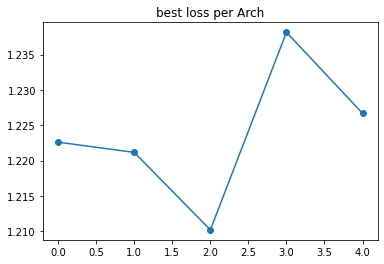

In [ ]:
plt.plot(Lss)
plt.scatter(range(len(archs)),cp.asnumpy(Lss))
plt.title("best loss per Arch")


## Learning rate optimization.

### get lr limits

In [ ]:
# find best lr
# lr limits
arch=[Xt.shape[1],256,256,5] #best arch from the above graph
high_lr=0.1
low_lr=0.0001
Lss=[]
for lr in [high_lr,low_lr]:
  Ann=ANN(len(arch)-1,arch) #Ann object
  H=Ann.Train(Xt,Yt,1000,lr,0,verbose=True)

  print("finished lr %f"%(lr))
  Lss.append(min(H['val_loss']))

Epoch 0 Train Loss is inf and Train Accuracy is   0.166842.. Val Loss is inf & Val Accuracy is 0.179811..
Epoch 50 Train Loss is 1.487438 and Train Accuracy is   0.358219.. Val Loss is 1.515974 & Val Accuracy is 0.324921..
Epoch 100 Train Loss is 2.968680 and Train Accuracy is   0.194883.. Val Loss is 2.965359 & Val Accuracy is 0.214511..
Epoch 150 Train Loss is 1.538708 and Train Accuracy is   0.283561.. Val Loss is 1.579540 & Val Accuracy is 0.258675..
Epoch 200 Train Loss is 1.497951 and Train Accuracy is   0.348756.. Val Loss is 1.544058 & Val Accuracy is 0.331230..
Epoch 250 Train Loss is 1.623078 and Train Accuracy is   0.262180.. Val Loss is 1.593692 & Val Accuracy is 0.302839..
Epoch 300 Train Loss is 1.428913 and Train Accuracy is   0.369786.. Val Loss is 1.489230 & Val Accuracy is 0.365931..
Epoch 350 Train Loss is 1.503108 and Train Accuracy is   0.310550.. Val Loss is 1.515045 & Val Accuracy is 0.318612..
Epoch 400 Train Loss is 1.372641 and Train Accuracy is   0.384157.. V

### run coarse search

In [ ]:
# coarse search for lr
#try 100 values
Lss={}
for i in range(100):
  lr=10**np.random.uniform(-1,-5) # limits of lr are 10^-1, 10^-4
  Ann=ANN(len(arch)-1,arch) #Ann object
  H=Ann.Train(Xt,Yt,200,lr,0,verbose=False)
  print("finished lr %f, min loss %f"%(lr,min(H['val_loss'])))
  Lss[lr]=(min(H['val_loss']))

Text(0.5, 1.0, 'best loss per lr')

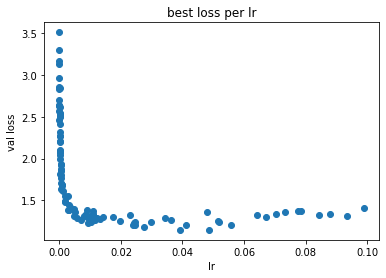

In [ ]:
ls=cp.asnumpy(list(Lss.values()))
plt.scatter(list(Lss.keys()),ls)
plt.xlabel("lr")
plt.ylabel('val loss')
plt.title("best loss per lr")

### run finer search

In [ ]:
# run finer search
Lss={}
for i in range(100):
  lr=10**np.random.uniform(-1,-2) # best lr is in 10^-2 range
  Ann=ANN(len(arch)-1,arch) #Ann object
  H=Ann.Train(Xt,Yt,500,lr,0,verbose=False)
  print("finished lr %f, min loss %f"%(lr,min(H['val_loss'])))
  Lss[lr]=(min(H['val_loss']))
  


Text(0.5, 1.0, 'best loss per lr')

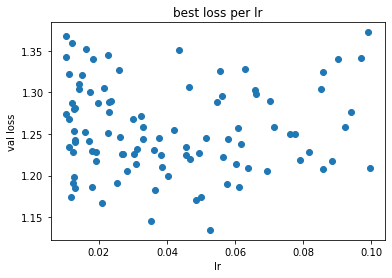

In [ ]:
ls2=cp.asnumpy(list(Lss.values()))
plt.scatter(list(Lss.keys()),ls2) # 
plt.xlabel("lr")
plt.ylabel('val loss')
plt.title("best loss per lr") # the best is around 0.05

## Get *best* Lambda 

In [ ]:
#choose best lambda
Lss={}
for i in range(100):
  ld=10**np.random.uniform(0,-1) # best ld is in > 10^-1 range
  Ann=ANN(len(arch)-1,arch) #Ann object
  H=Ann.Train(Xt,Yt,500,0.055,ld,verbose=False) #best lr
  #print("finished ld %f, min loss %f"%(ld,min(H['val_loss'])))
  Lss[ld]=(min(H['val_loss']))


In [ ]:
# try no reg.
Ann=ANN(len(arch)-1,arch) #Ann object
H=Ann.Train(Xt,Yt,500,0.05,0,verbose=False) #best lr
#print("finished ld %f, min loss %f"%(ld,min(H['val_loss'])))
ls_0=(min(H['val_loss']))

Text(0.5, 1.0, 'best loss per lambda')

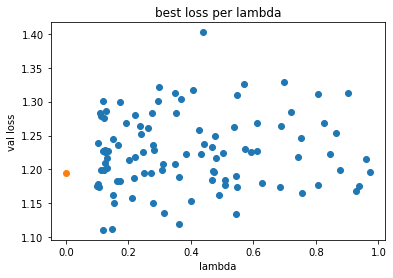

In [ ]:
#no regulization
ls3=cp.asnumpy(list(Lss.values()))
plt.scatter(list(Lss.keys()),ls3) # 
plt.scatter(0,cp.asnumpy(ls_0))
plt.xlabel("lambda")
plt.ylabel('val loss')
plt.title("best loss per lambda") # the best lambda 0.1

#Use best parameters for training

In [ ]:
mu=Xt.mean(axis=0)
si=Xt.std(axis=0)
Xt-=mu
Xt/=si

In [ ]:
n_nodes=[Xt.shape[1],256,256,5] #Best ANN Architecture
Ann=ANN(len(n_nodes)-1,n_nodes) #Ann object
H=Ann.Train(Xt,Yt,1000,.0011,0.1) # best lr., 0.1 lambda regulrization

Epoch 0 Train Loss is 17.902232 and Train Accuracy is   0.184367.. Val Loss is 17.704297 & Val Accuracy is 0.189274..
Epoch 50 Train Loss is 4.025685 and Train Accuracy is   0.388013.. Val Loss is 4.983820 & Val Accuracy is 0.356467..
Epoch 100 Train Loss is 2.925177 and Train Accuracy is   0.464774.. Val Loss is 4.154072 & Val Accuracy is 0.388013..
Epoch 150 Train Loss is 2.320187 and Train Accuracy is   0.519453.. Val Loss is 3.796017 & Val Accuracy is 0.413249..
Epoch 200 Train Loss is 1.902604 and Train Accuracy is   0.563968.. Val Loss is 3.586303 & Val Accuracy is 0.422713..
Epoch 250 Train Loss is 1.590231 and Train Accuracy is   0.604627.. Val Loss is 3.445991 & Val Accuracy is 0.432177..
Epoch 300 Train Loss is 1.348302 and Train Accuracy is   0.648090.. Val Loss is 3.345585 & Val Accuracy is 0.438486..
Epoch 350 Train Loss is 1.154703 and Train Accuracy is   0.691553.. Val Loss is 3.273785 & Val Accuracy is 0.438486..
Epoch 400 Train Loss is 0.997648 and Train Accuracy is   

## Plot Val and Train Loss and Accuracies

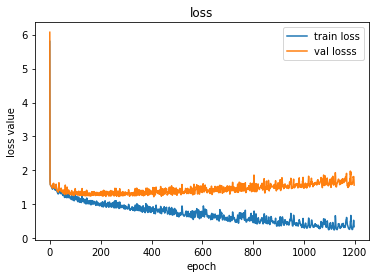

In [ ]:
import matplotlib.pyplot as plt
plt.plot(H['train_loss'][3:])
plt.plot(H['val_loss'][3:])
plt.legend(('train loss','val losss'))
plt.title('loss')
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.show()

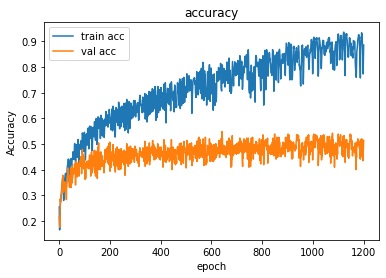

In [ ]:
plt.plot(H['train_acc'])
plt.plot(H['val_acc'])
plt.legend(('train acc','val acc'))
plt.title('accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.show()

## CCRN for classes

In [ ]:
ccrns=Ann.CCRn(y_test,X_test)
names=["daisy", "dandelion", "roses", "sunflowers", "tulips"]
print((ccrns))
for k in sorted(ccrns):
  print( 'accuracy for class %d (%s) is %f'%(k,names[k-1],ccrns[k]))

{4: 0.75, 1: 0.38, 5: 0.58, 3: 0.45, 2: 0.53}
accuracy for class 1 (daisy) is 0.380000
accuracy for class 2 (dandelion) is 0.530000
accuracy for class 3 (roses) is 0.450000
accuracy for class 4 (sunflowers) is 0.750000
accuracy for class 5 (tulips) is 0.580000


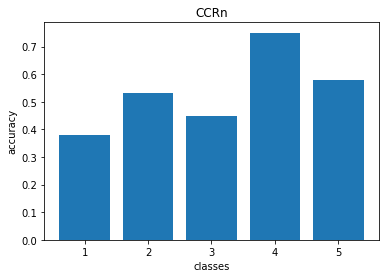

In [ ]:
#represent them in bar chart
plt.bar(ccrns.keys(),ccrns.values())
plt.xlabel("classes")
plt.ylabel("accuracy")
plt.title("CCRn")
plt.show()

## ACCR for all classes

In [ ]:
print("Average Accuracy ",Ann.evaluate((X_test-mu)/si,y_test))

Average Accuracy  0.404


In [ ]:
# if the model is better save it
Ann.save_model('model_reg2')

# Load the best Models and print best ACCR

In [ ]:
#Load the best model with no regularization
Ann.load_model('/content/drive/My Drive/PMDL/A2/model_no_reg.pickle')

In [ ]:
print(Ann.n_layers)
print("Best reg Model Arch and parameters (lr, lambda): ", Ann.n_nodes,Ann.lr, Ann.ld)
print("Best reg model Average Accuracy ",Ann.evaluate(X_test,y_test))
print("Best reg model  Accuracy on training set ",Ann.evaluate(Xt,Yt))

3
Best reg Model Arch and parameters (lr, lambda):  [3072, 256, 256, 5] 0.055 0
Best reg model Average Accuracy  0.542
Best reg model  Accuracy on training set  0.47318611987381703


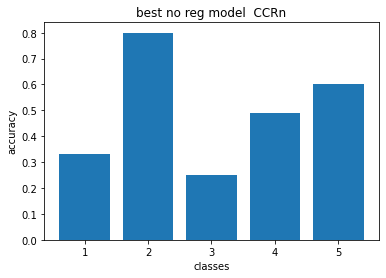

In [ ]:
#represent them in bar chart
plt.bar(ccrns.keys(),ccrns.values())
plt.xlabel("classes")
plt.ylabel("accuracy")
plt.title("best no reg model  CCRn")
plt.show()

In [ ]:
#Load the best model with regularization
Ann.load_model('/content/drive/My Drive/PMDL/A2/model_L2reg.pickle')

In [ ]:
print(Ann.n_layers)
print("Best reg Model Arch and parameters (lr, lambda): ", Ann.n_nodes,Ann.lr, Ann.ld)
print("Best reg model Average Accuracy ",Ann.evaluate(X_test,y_test))

3
Best reg Model Arch and parameters (lr, lambda):  [3072, 256, 256, 5] 0.055 0.1
Best reg model Average Accuracy  0.538


In [ ]:
print("Best reg model  Accuracy on training set ",Ann.evaluate(Xt,Yt))

Best reg model  Accuracy on training set  0.8936908517350157


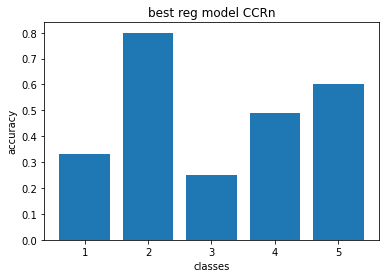

In [ ]:
#represent them in bar chart
plt.bar(ccrns.keys(),ccrns.values())
plt.xlabel("classes")
plt.ylabel("accuracy")
plt.title("best reg model CCRn")
plt.show()

# Compare against TF model of the same Architecture

In [ ]:
# try an equivalant tensorflow model
X_train=cp.asnumpy(Xt)
y_train=cp.asnumpy(Yt)
Y=keras.utils.to_categorical((y_train).reshape(-1,1))
Y=Y[:,1:]

In [ ]:
import tensorflow as tf
keras=tf.keras
model=keras.Sequential()
model.add(keras.layers.Input(X_train.shape[1:]))


model.add(keras.layers.Dense(256,'relu'))

model.add(keras.layers.Dense(256,'relu'))

model.add(keras.layers.Dense(5,'softmax'))
model.compile(keras.optimizers.Adam(),loss=keras.losses.categorical_crossentropy,metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 256)               786688    
_________________________________________________________________
dense_25 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_26 (Dense)             (None, 5)                 1285      
Total params: 853,765
Trainable params: 853,765
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit((X_train),Y,batch_size=1024,epochs=150,validation_split=0.1)

Epoch 1/150
3/3 [==============================] - 0s 44ms/step - loss: 2.1381 - accuracy: 0.2646 - val_loss: 1.8147 - val_accuracy: 0.2776
Epoch 2/150
3/3 [==============================] - 0s 12ms/step - loss: 1.6671 - accuracy: 0.2503 - val_loss: 1.6068 - val_accuracy: 0.2839
Epoch 3/150
3/3 [==============================] - 0s 12ms/step - loss: 1.5015 - accuracy: 0.3743 - val_loss: 1.4507 - val_accuracy: 0.3785
Epoch 4/150
3/3 [==============================] - 0s 11ms/step - loss: 1.4178 - accuracy: 0.3757 - val_loss: 1.4170 - val_accuracy: 0.3943
Epoch 5/150
3/3 [==============================] - 0s 12ms/step - loss: 1.3713 - accuracy: 0.4182 - val_loss: 1.4085 - val_accuracy: 0.3596
Epoch 6/150
3/3 [==============================] - 0s 11ms/step - loss: 1.3236 - accuracy: 0.4322 - val_loss: 1.3734 - val_accuracy: 0.3943
Epoch 7/150
3/3 [==============================] - 0s 12ms/step - loss: 1.2893 - accuracy: 0.4487 - val_loss: 1.3338 - val_accuracy: 0.4101
Epoch 8/150
3/3 [===

In [ ]:
ty=keras.utils.to_categorical(cp.asnumpy(y_test).reshape(-1,1))
ty=ty[:,1:]
print(" TF Avg Acc", model.evaluate(cp.asnumpy(X_test),ty))

16/16 [==============================] - 0s 2ms/step - loss: 1.9222 - accuracy: 0.4900
 TF Avg Acc [1.9221936464309692, 0.49000000953674316]
